# New collaborations are driven by research trends

### Brief overview


### Imports & Global Variables

In [11]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd
from box import Box
from util.postgres import create_sqlalchemy_connection, query

In [2]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_connection = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)

In [3]:
sql_query = """
SELECT *
FROM fct_article_keyword_trend
"""

df = query(conn=pg_connection, query_str=sql_query)
df.head(5)

,article_keyword,research_area_code,article_publication_year,publication_count,publication_normalized_count,publication_count_yoy,publication_count_yoy_3yr_rolling_avg,publication_count_baseline,publication_normalized_count_baseline,publication_count_yoy_baseline,publication_count_yoy_3yr_rolling_avg_baseline,publication_count_yoy_3yr_rolling_avg_diff,publication_count_yoy_3yr_rolling_avg_diff_pct,is_trend_positive
0,(Bi,P351,2000,1427,225.0,NaN,NaN,5542.5,875.5,NaN,NaN,NaN,NaN,False
1,(Bi,P351,2001,1577,248.0,0.102222,0.102222,5572.5,878.5,0.018405,0.018405,0.083817,4.0,True
2,(Bi,P351,2002,2726,429.0,0.729839,0.416030,5782.0,910.5,0.023095,0.012889,0.403141,31.0,True
3,(Bi,P351,2003,1828,286.0,-0.333333,0.166243,6262.5,981.5,0.075000,0.033155,0.133087,4.0,True
4,(Bi,P351,2004,2145,332.0,0.160839,0.185782,7279.0,1129.0,0.109136,0.068271,0.117511,1.0,True


In [4]:
keyword = 'computer vision'
df_keyword = df[df['article_keyword'] == keyword]


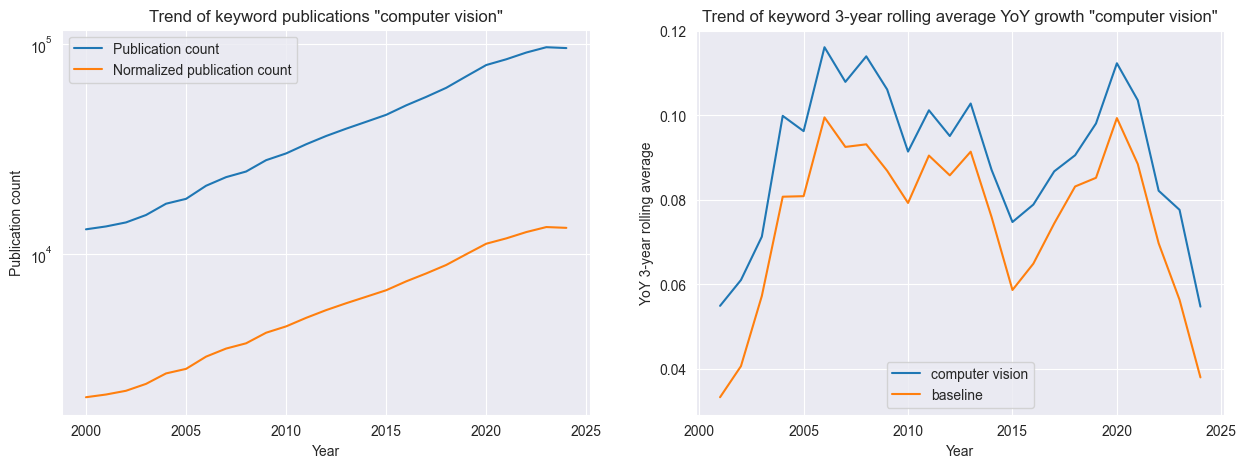

In [5]:
# Visualize the trend of the keyword
df_keyword = df_keyword.sort_values(by='article_publication_year')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.lineplot(data=df, x='article_publication_year', y='publication_count', errorbar=None, ax=axs[0])
sns.lineplot(data=df, x='article_publication_year', y='publication_normalized_count', errorbar=None, ax=axs[0])
axs[0].set_title(f'Trend of keyword publications "{keyword}"')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Publication count')
axs[0].legend(['Publication count', 'Normalized publication count'])
axs[0].set_yscale('log')

sns.lineplot(data=df, x='article_publication_year', y='publication_count_yoy_3yr_rolling_avg', errorbar=None, ax=axs[1])
sns.lineplot(data=df, x='article_publication_year', y='publication_count_yoy_3yr_rolling_avg_baseline', errorbar=None,
             ax=axs[1])
axs[1].set_title(f'Trend of keyword 3-year rolling average YoY growth "{keyword}"')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('YoY 3-year rolling average')
axs[1].legend([keyword, 'baseline'])
plt.show()

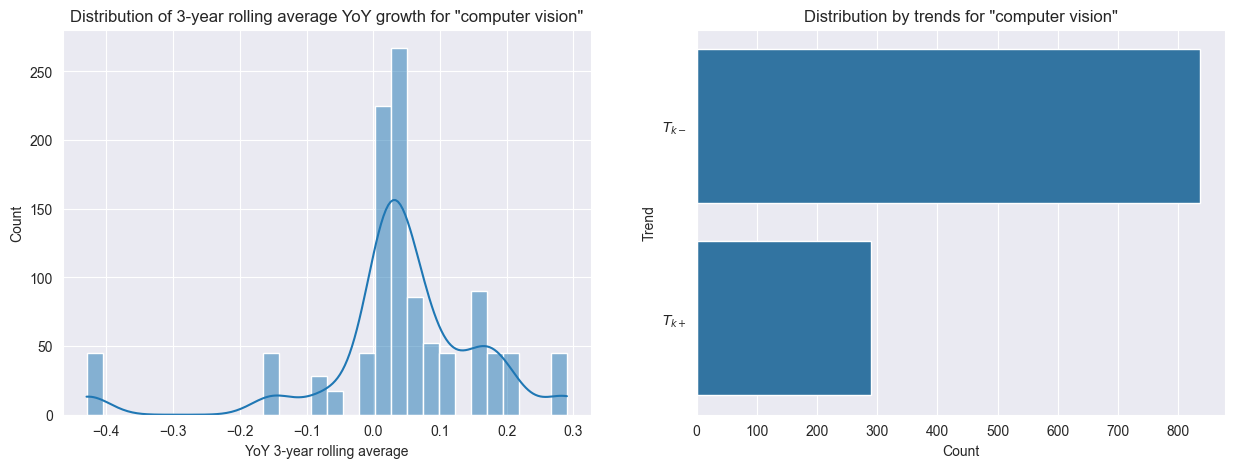

In [6]:
# Visualize the distribution of the positive versus negative trends
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(data=df_keyword, x='publication_count_yoy_3yr_rolling_avg', bins=30, kde=True, ax=axs[0])
axs[0].set_title(f'Distribution of 3-year rolling average YoY growth for "{keyword}"')
axs[0].set_xlabel('YoY 3-year rolling average')

# Visualize barplot of the positive versus negative trends counting the number of occurrences of distinct keywords, years and research areas
df_keyword['unique_id'] = list(
    map(lambda x, y, z: f'{x}_{y}_{z}', df_keyword['article_publication_year'], df_keyword['article_keyword'],
        df_keyword['research_area_code']))

df_keyword['positive_trend'] = df_keyword['is_trend_positive'].apply(lambda x: '$T_{k+}$' if x else '$T_{k-}$')
df_keyword['positive_trend'] = df_keyword['positive_trend'].astype('category')

sns.countplot(data=df_keyword, y='positive_trend', ax=axs[1], orient='h',
              order=df_keyword['positive_trend'].value_counts().index)
axs[1].set_title(f'Distribution by trends for "{keyword}"')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Trend')
plt.show()

In [3]:
sql_query = """
SELECT *
FROM fct_article_by_keyword_popularity
"""

df_popularity = query(conn=pg_connection, query_str=sql_query)
df_popularity['is_new_collaboration'] = np.where(df_popularity['collaboration_type'] == 'new', 1, 0)
df_popularity.head(5)

,article_id,collaboration_type,keyword_popularity,keyword_popularity_index,is_new_collaboration
0,0041894406,existing,1,0.029079,0
1,10.1002/anie.201406246,new,0,-0.036965,1
2,10.1002/bate.201300058,new,2,0.099187,1
3,10.1002/casp.2217,new,0,-0.020109,1
4,10.1002/chem.201403730,new,0,-0.080133,1


In [8]:
# Sample the data so that we'll have a balanced dataset over collabroation types
n_new_collaborations = df_popularity['is_new_collaboration'].sum()
n_existing_collaborations = df_popularity.shape[0] - n_new_collaborations
min_collaboration_count = min(n_new_collaborations, n_existing_collaborations)
print(f'Number of new collaborations: {n_new_collaborations}')
print(f'Number of existing collaborations: {n_existing_collaborations}')

Number of new collaborations: 25905
Number of existing collaborations: 2695


In [16]:
min_collaboration_count = 100
df_popularity_positive = df_popularity[df_popularity['is_new_collaboration'] == 1].sample(n=min_collaboration_count)
df_popularity_negative = df_popularity[df_popularity['is_new_collaboration'] == 0].sample(n=min_collaboration_count)
df_popularity_sampled = pd.concat([df_popularity_positive, df_popularity_negative])

In [14]:
print(df_popularity_sampled['is_new_collaboration'].value_counts())
print(df_popularity_sampled['keyword_popularity'].value_counts())

is_new_collaboration
1    2695
0    2695
Name: count, dtype: int64
keyword_popularity
0    3174
1    1989
2     206
3      20
4       1
Name: count, dtype: int64


In [17]:

with pm.Model() as model:
    # Priors on intercept and slope
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_pop = pm.Normal("beta_pop", mu=0, sigma=10)

    # Linear predictor: logit(p_i) = alpha + beta_pop * popularity_i
    mu = alpha + beta_pop * df_popularity_sampled["keyword_popularity"].values

    # Convert to probability via the logistic function
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    # Observed data: Bernoulli trials (is_new_collab ∈ {0,1})
    y_obs = pm.Bernoulli("y_obs", p=p, observed=df_popularity_sampled["is_new_collaboration"].values)

    # Sample from the posterior
    trace = pm.sample(
        draws=3000,  # post-warmup draws
        tune=1000,  # warmup (tuning) draws
        target_accept=0.9,
        random_seed=42,
        progressbar=True
    )

# Summary of posterior
az.summary(trace, var_names=["alpha", "beta_pop"], hdi_prob=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_pop]


Output()

ValueError: Not enough samples to build a trace.